# La Pseudo-Labellisation, ou l'art de faire confiance à son modèle (avec modération)

Bienvenue dans ce premier chapitre pratique ! Aujourd'hui, on s'attaque à un classique de l'apprentissage semi-supervisé : la **pseudo-labellisation**. L'idée ? Si un modèle est suffisamment sûr de sa prédiction sur une image non labellisée, pourquoi ne pas lui faire confiance et utiliser cette prédiction comme un "vrai" label ?

> C'est un peu comme demander à un élève de corriger ses propres copies. Risqué, mais si on le guide bien, ça peut marcher !

**Objectifs du jour :**
1. Entraîner un premier modèle sur très peu de données.
2. Utiliser ce modèle pour générer des pseudo-labels sur des données non labellisées.
3. Implémenter la boucle de pseudo-labellisation pour ré-entraîner le modèle.
4. Comprendre l'importance du **seuil de confiance** et de la **calibration**.

## 1. Préparation de l'environnement et des données

On commence par les bases : importer les librairies et charger notre dataset, `DermaMNIST`. C'est un jeu de données d'images de lésions cutanées. Notre mission : les classifier correctement, même avec une poignée de labels.

DermaMNIST fait partie de la famille des datasets **MedMNIST**, une collection standardisée de datasets d'images médicales, tous au format 28x28 et organisés de manière similaire aux célèbres datasets MNIST. L'objectif de MedMNIST est de faciliter la recherche et la comparaison de modèles d'apprentissage automatique sur des tâches médicales.

Le dataset DermaMNIST est basé sur le HAM10000, une large collection d'images de dermatoscopie. Il contient des images de 7 classes différentes de lésions cutanées. Son intérêt pédagogique est majeur : il permet d'aborder des problèmes de classification d'images médicales avec un dataset de taille raisonnable, tout en simulant des scénarios de faible quantité de données labellisées, parfait pour explorer des techniques comme la pseudo-labellisation.

Les 7 classes de lésions cutanées sont :

    0: actinic keratoses and intraepithelial carcinoma
    1: basal cell carcinoma
    2: benign keratosis-like lesions
    3: dermatofibroma
    4: melanoma
    5: melanocytic nevi
    6: vascular lesions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Subset
from torchvision import transforms
import torchvision.models as models
import medmnist
from medmnist import INFO, Evaluator
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.semi_supervised import LabelSpreading
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

# Pour la reproductibilité, parce qu'on est des gens sérieux
torch.manual_seed(42)
np.random.seed(42)

### 📦 Chargement du dataset DermaMNIST

La librairie `medmnist` nous simplifie la vie. On télécharge les données et on les prépare.

In [2]:
# Nom du dataset à charger
data_flag = 'dermamnist'
# Récupère les informations spécifiques à ce dataset depuis medmnist
info = INFO[data_flag]

# Ajout de prints pour mieux comprendre le dataset
print(f"Dataset chargé : {data_flag}")

# Extrait le type de tâche (classification, régression, etc.)
task = info['task']
print(f"Type de tâche : {task}")

# Extrait le nombre de canaux des images (3 pour RGB, 1 pour niveaux de gris)
n_channels = info['n_channels']
print(f"Nombre de canaux : {n_channels}")

# Extrait le nombre de classes pour la classification
n_classes = len(info['label'])
print(f"Nombre de classes : {n_classes}")

# Récupère la classe Python spécifique pour ce dataset
DataClass = getattr(medmnist, info['python_class'])

# Transformations: on sépare train/test et on ajoute des augmentations légères pour mieux généraliser
# Normalisation explicite 3 canaux
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Charge les datasets d'entraînement et de test
train_dataset = DataClass(split='train', transform=transform_train, download=True)
test_dataset = DataClass(split='test', transform=transform_test, download=True)

print(f"Taille du jeu d'entraînement : {len(train_dataset)}")
print(f"Taille du jeu de test : {len(test_dataset)}")

Dataset chargé : dermamnist
Type de tâche : multi-class
Nombre de canaux : 3
Nombre de classes : 7
Taille du jeu d'entraînement : 7007
Taille du jeu de test : 2005


### 🧪 Pourquoi ces transformations ? (Pédagogie)

Nous séparons désormais clairement l'entraînement et le test et ajoutons de **légères augmentations** (flip horizontal, petite rotation, léger jitter de contraste/luminosité) côté train. 

- Objectif: améliorer la généralisation avec seulement 350 images labellisées.
- Risque maîtrisé: ces augmentations restent plausibles pour DermaMNIST et n’altèrent pas le diagnostic visuel.
- Normalisation: explicite sur **3 canaux** (`mean=[0.5,0.5,0.5]`, `std=[0.5,0.5,0.5]`) pour clarifier l’intention.

Attendez-vous à de légers gains de stabilité/robustesse par rapport à l’entraînement sans augmentations.

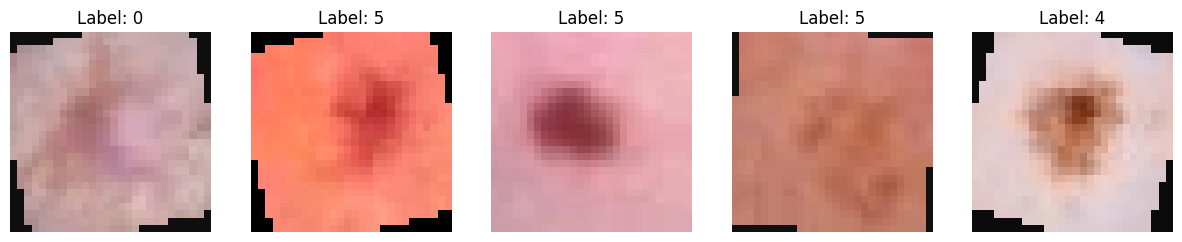

In [3]:
# Visualisation de quelques exemples
num_examples = 5
fig, axes = plt.subplots(1, num_examples, figsize=(15, 3))

for i in range(num_examples):
    # Récupère une image et son label
    image, label = train_dataset[i]
    # L'image est un tensor, on le convertit en numpy array et on le transpose pour l'affichage
    # On dénormalise aussi l'image pour un affichage correct
    img = image.numpy().transpose(1, 2, 0) * 0.5 + 0.5
    axes[i].imshow(img.squeeze(), cmap='gray') # Use cmap='gray' for single channel images if needed
    axes[i].set_title(f"Label: {label.item()}")
    axes[i].axis('off')

plt.show()

### 🧩 Création des jeux de données : Étiqueté vs. Non-étiqueté

C'est ici que la magie du semi-supervisé opère. On va simuler une situation où on a très peu de données labellisées et un grand volume de données dont on ignore la classe.

On va prendre seulement **50 images par classe** pour l'entraînement étiqueté (350 images au total). Le reste du jeu d'entraînement sera notre vivier de données non-labellisées.

In [4]:
# On prend tout le set d'entraînement initial
all_indices = list(range(len(train_dataset)))
labels_array = np.array(train_dataset.labels).flatten()

# Sélectionner 50 images par classe
labeled_indices = []
for c in range(n_classes):
    class_indices = np.where(labels_array == c)[0]
    selected = np.random.choice(class_indices, min(50, len(class_indices)), replace=False)
    labeled_indices.extend(selected)

# Les indices non étiquetés sont le reste
unlabeled_indices = list(set(all_indices) - set(labeled_indices))

# Création des Subsets PyTorch
labeled_dataset = Subset(train_dataset, labeled_indices)
unlabeled_dataset = Subset(train_dataset, unlabeled_indices)

print(f"Taille du jeu de données étiqueté : {len(labeled_dataset)}")
print(f"Taille du jeu de données non-étiqueté : {len(unlabeled_dataset)}")
print(f"Taille du jeu de test : {len(test_dataset)}")

# DataLoaders
labeled_loader = DataLoader(dataset=labeled_dataset, batch_size=16, shuffle=True)
unlabeled_loader = DataLoader(dataset=unlabeled_dataset, batch_size=128, shuffle=False) # Pas besoin de shuffle ici
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

Taille du jeu de données étiqueté : 350
Taille du jeu de données non-étiqueté : 6657
Taille du jeu de test : 2005


### 🎓 Objectif pédagogique

Nous allons rendre le notebook plus explicite et mesurable:
- **Suivre des métriques** (AUC, Accuracy, F1 macro) à chaque étape.
- **Visualiser** une matrice de confusion après entraînement.
- **Documenter** nos choix (augmentations, seuils de pseudo‑labels) pour interpréter les résultats—bons ou moins bons.

Distribution des classes dans le 'labeled_dataset' (350 images) :

Classe 0 (actinic keratoses and intraepithelial carcinoma): 50 images
Classe 1 (basal cell carcinoma): 50 images
Classe 2 (benign keratosis-like lesions): 50 images
Classe 3 (dermatofibroma): 50 images
Classe 4 (melanoma): 50 images
Classe 5 (melanocytic nevi): 50 images
Classe 6 (vascular lesions): 50 images


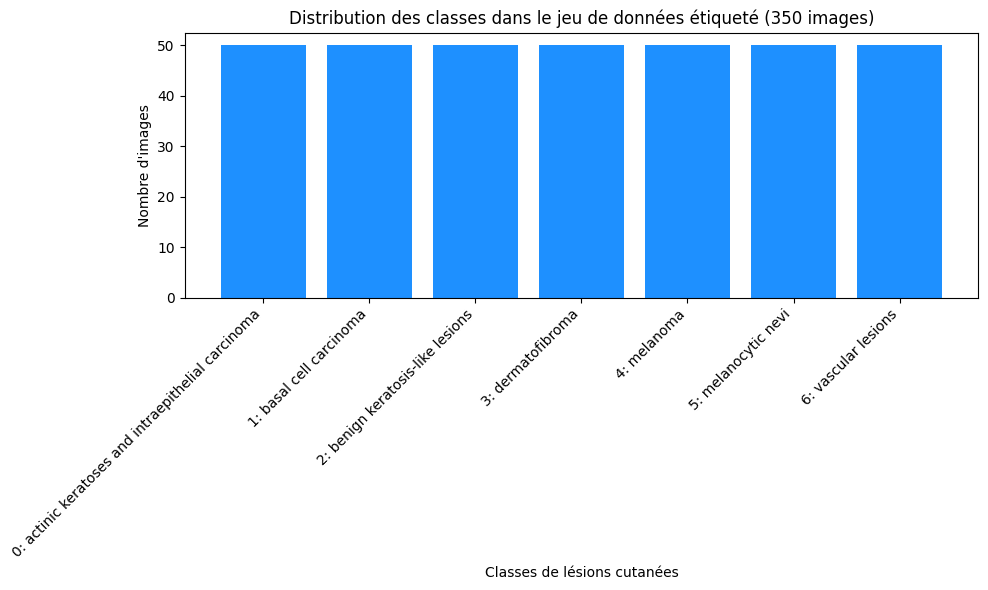

In [5]:
# Les labels du dataset complet sont dans train_dataset.labels
# On récupère les labels correspondant aux indices de notre jeu étiqueté
labels_of_labeled_set = train_dataset.labels[labeled_indices]

# Compter le nombre d'occurrences de chaque classe
class_counts = np.bincount(np.array(labels_of_labeled_set).flatten(), minlength=n_classes)
class_names = [f'{i}: {name}' for i, name in info['label'].items()]

# Afficher les comptes
print("Distribution des classes dans le 'labeled_dataset' (350 images) :\n")
for i, count in enumerate(class_counts):
    # Récupérer le nom complet de la classe
    full_class_name = info['label'][str(i)]
    print(f"Classe {i} ({full_class_name}): {count} images")

# Créer un graphique à barres pour visualiser la distribution
plt.figure(figsize=(10, 6))
plt.bar(class_names, class_counts, color='dodgerblue')
plt.xlabel('Classes de lésions cutanées')
plt.ylabel("Nombre d'images")
plt.title("Distribution des classes dans le jeu de données étiqueté (350 images)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### 📈 Suivi et initialisation des métriques

Nous allons initialiser trois listes globales `metrics_auc`, `metrics_acc`, `metrics_f1` pour tracer l’évolution au fil des itérations. Cela permet de diagnostiquer la dérive potentielle et d’argumenter pédagogiquement nos choix (seuils, marge, quotas).

## 2. Le Modèle de Base (Supervisé)

On va d'abord entraîner un modèle simple (un petit réseau de neuronnes convolutifs (CNN)) uniquement sur nos 350 images labellisées. On s'attend à une performance... modeste. C'est notre point de départ.

In [6]:
# Définition d'un petit CNN (vous pouvez l'améliorer !)
class SimpleCNN(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(SimpleCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7 * 7 * 32, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

# Définir le device (à mettre au début de votre code si ce n'est pas déjà fait)
device = torch.device("cpu")

# On instancie la loss (sans poids car dataset équilibré)
criterion = nn.CrossEntropyLoss()

# On déplace aussi le modèle sur le device
model = SimpleCNN(in_channels=n_channels, num_classes=n_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### 📊 Suivi des métriques au fil des itérations

Nous allons suivre **AUC**, **Accuracy** et **F1 macro** à chaque itération de pseudo‑labeling pour rendre visible l'impact de nos choix (seuils, marge, volumes ajoutés). Cette traçabilité aide à expliquer les améliorations… ou les régressions.

### ⚙️ Initialisation des métriques

Nous initialisons des listes globales pour tracer AUC, Accuracy et F1 macro après chaque étape/clé du workflow.

In [7]:
# Listes globales pour tracer les métriques au fil des étapes
metrics_auc, metrics_acc, metrics_f1 = [], [], []


def plot_metrics():
    """Trace l'évolution des AUC/Accuracy/F1 macro si des valeurs sont disponibles."""
    if len(metrics_auc) == 0:
        print("Aucune métrique enregistrée pour le moment.")
        return
    steps = range(1, len(metrics_auc) + 1)
    plt.figure(figsize=(8, 4))
    plt.plot(steps, metrics_auc, label='AUC')
    plt.plot(steps, metrics_acc, label='Accuracy')
    plt.plot(steps, metrics_f1, label='F1 (macro)')
    plt.xlabel('Étape / Itération')
    plt.ylabel('Score')
    plt.title("Évolution des métriques")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [8]:
def train_and_evaluate(model, train_loader, test_loader, optimizer, criterion, epochs=10):
    """
    Entraîne et évalue un modèle. Retourne (AUC, ACC, F1).
    Si des listes globales metrics_auc/metrics_acc/metrics_f1 existent, y ajoute les scores.
    """
    device = next(model.parameters()).device

    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.squeeze().long().to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Évaluation
    model.eval()
    y_true = torch.tensor([]).to(device)
    y_score_logits = torch.tensor([]).to(device)
    y_score_preds = torch.tensor([]).to(device)
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            y_true = torch.cat((y_true, labels), 0)
            y_score_logits = torch.cat((y_score_logits, outputs), 0)
            preds = torch.argmax(outputs, dim=1)
            y_score_preds = torch.cat((y_score_preds, preds), 0)

    y_true = y_true.squeeze().cpu().numpy()
    y_score_logits = y_score_logits.detach().cpu().numpy()
    y_score_preds = y_score_preds.detach().cpu().numpy()

    evaluator = Evaluator(data_flag, 'test')
    auc, acc = evaluator.evaluate(y_score_logits)
    f1 = f1_score(y_true, y_score_preds, average='macro')

    try:
        metrics_auc.append(auc)
        metrics_acc.append(acc)
        metrics_f1.append(f1)
    except NameError:
        pass

    print(f'AUC: {auc:.3f}, Accuracy: {acc:.3f}, F1: {f1:.3f}')
    return (auc, acc, f1)

print("Entraînement du modèle de base sur 350 images labellisées...")
baseline_metrics = train_and_evaluate(model, labeled_loader, test_loader, optimizer, criterion)


Entraînement du modèle de base sur 350 images labellisées...
AUC: 0.824, Accuracy: 0.489, F1: 0.234


## 3. La Pseudo-Labellisation à la rescousse !

Le score de base est probablement... bof. C'est normal !
Maintenant, on va mettre en place la boucle de pseudo-labellisation.

**Le principe :**
1. **Prédire** sur les données non labellisées.
2. **Sélectionner** les prédictions où le modèle est le plus confiant (au-dessus d'un certain `seuil`).
3. **Ajouter** ces prédictions (images + pseudo-labels) au jeu d'entraînement étiqueté.
4. **Ré-entraîner** le modèle sur ce nouveau jeu de données augmenté.
5. Répéter !

Génération des pseudo-labels :
1. Parcourir le `unlabeled_loader`.
2. Obtenir les prédictions du modèle.
3. Appliquer un `softmax` pour avoir des probabilités.
4. Identifier la probabilité maximale (`probs`) et la classe prédite (`preds`) pour chaque image.
5. Ne garder que les images où `probs` est supérieur au `threshold`.
6. Retourner les indices de ces images et leurs pseudo-labels.

In [9]:
def get_pseudo_labels(model, unlabeled_loader, threshold=0.95):
    """Génère des pseudo-labels pour les données où le modèle est confiant."""
    model.eval()
    pseudo_labeled_indices = []
    pseudo_labels = []

    with torch.no_grad():
        for i, (images, _) in enumerate(unlabeled_loader):
            # Déplacer les images sur le même appareil que le modèle (GPU si disponible)
            images = images.to(next(model.parameters()).device)

            # 1. Obtenir les prédictions (logits)
            outputs = model(images)

            # 2. Calculer les probabilités (softmax)
            probabilities = torch.softmax(outputs, dim=1)

            # 3. Obtenir la proba max et la classe prédite
            max_probs, predicted_classes = torch.max(probabilities, dim=1)

            # 4. Filtrer selon le seuil
            confident_mask = max_probs > threshold

            # 5. Récupérer les indices et les labels
            # Les indices dans le DataLoader ne correspondent pas aux indices dans le dataset original
            # Il faut donc calculer les indices réels dans le unlabeled_dataset
            batch_start_index = i * unlabeled_loader.batch_size
            original_indices_in_unlabeled_dataset = torch.arange(batch_start_index, batch_start_index + images.size(0))

            # On utilise les indices originaux dans le unlabeled_dataset pour accéder aux indices dans le train_dataset complet
            original_indices = [unlabeled_loader.dataset.indices[j] for j in original_indices_in_unlabeled_dataset[confident_mask]]

            confident_labels = predicted_classes[confident_mask]


            pseudo_labeled_indices.extend(original_indices)
            pseudo_labels.extend(confident_labels.tolist())

    print(f"Nombre d'images pour lesquelles le modèle est confiant (> {threshold:.2f}) : {len(pseudo_labeled_indices)}")
    return pseudo_labeled_indices, pseudo_labels

### 🔁 La grande boucle de pseudo-labellisation

Maintenant, on assemble tout. On va faire plusieurs itérations de pseudo-labellisation.

In [10]:
# On réinitialise le modèle et l'optimiseur
ssl_model = SimpleCNN(in_channels=n_channels, num_classes=n_classes).to(device)
ssl_optimizer = torch.optim.Adam(ssl_model.parameters(), lr=0.001)

# On commence avec le jeu de données étiqueté de base
current_labeled_indices = list(labeled_indices)

for iteration in range(5): # 5 itérations de pseudo-labellisation
    print(f'--- Itération {iteration+1} ---')

    # On crée le dataset d'entraînement actuel
    iter_dataset = Subset(train_dataset, current_labeled_indices)
    iter_loader = DataLoader(iter_dataset, batch_size=32, shuffle=True)

    # 1. Entraîner le modèle
    print(f'Entraînement sur {len(iter_dataset)} images...')
    pseudo_label_auc, pseudo_label_acc, pseudo_label_f1 = train_and_evaluate(ssl_model, iter_loader, test_loader, ssl_optimizer, criterion, epochs=5)

    # 2. Générer des pseudo-labels
    print('Génération de pseudo-labels...')
    pseudo_indices, pseudo_labels = get_pseudo_labels(ssl_model, unlabeled_loader, threshold=0.9)
    print(f'{len(pseudo_indices)} nouveaux pseudo-labels ajoutés.')

    # 3. Mettre à jour le dataset d'entraînement
    temp_dataset = train_dataset
    for idx, label in zip(pseudo_indices, pseudo_labels):
        # On ne modifie que les labels des images qu'on a pseudo-labellisées
        if idx not in current_labeled_indices: # Pour ne pas écraser les vrais labels
            temp_dataset.labels[idx] = label
            current_labeled_indices.append(idx)

    if len(pseudo_indices) == 0:
        print("Plus de pseudo-labels trouvés, on arrête là !")
        break

--- Itération 1 ---
Entraînement sur 350 images...
AUC: 0.805, Accuracy: 0.547, F1: 0.290
Génération de pseudo-labels...
Nombre d'images pour lesquelles le modèle est confiant (> 0.90) : 786
786 nouveaux pseudo-labels ajoutés.
--- Itération 2 ---
Entraînement sur 1136 images...
AUC: 0.845, Accuracy: 0.586, F1: 0.308
Génération de pseudo-labels...
Nombre d'images pour lesquelles le modèle est confiant (> 0.90) : 2330
2330 nouveaux pseudo-labels ajoutés.
--- Itération 3 ---
Entraînement sur 2690 images...
AUC: 0.852, Accuracy: 0.585, F1: 0.295
Génération de pseudo-labels...
Nombre d'images pour lesquelles le modèle est confiant (> 0.90) : 2896
2896 nouveaux pseudo-labels ajoutés.
--- Itération 4 ---
Entraînement sur 3410 images...
AUC: 0.846, Accuracy: 0.598, F1: 0.289
Génération de pseudo-labels...
Nombre d'images pour lesquelles le modèle est confiant (> 0.90) : 3430
3430 nouveaux pseudo-labels ajoutés.
--- Itération 5 ---
Entraînement sur 3932 images...
AUC: 0.844, Accuracy: 0.605, F1

In [11]:
# Chemin où sauvegarder le modèle
model_save_path = 'dermamnist_ssl_model.pth'

# On sauvegarde uniquement les poids du modèle (c'est la meilleure pratique)
torch.save(ssl_model.state_dict(), model_save_path)

print(f"Modèle sauvegardé avec succès dans : {model_save_path}")

Modèle sauvegardé avec succès dans : dermamnist_ssl_model.pth


## 4. Analyse et Questions de Réflexion

A-t-on amélioré le score ? Normalement, oui ! Mais à quel prix ?

**Questions pour aller plus loin :**
1. **L'impact du seuil** : Que se passe-t-il si vous baissez le seuil à 0.8 ? Et si vous l'augmentez à 0.99 ? Un seuil bas risque d'introduire du bruit (mauvais labels), un seuil haut risque de ne sélectionner que les exemples "faciles".
2. **La dérive de confirmation** : Le modèle devient de plus en plus confiant dans ses propres erreurs. Comment pourrait-on limiter ce phénomène ? (Indice : calibration, régularisation...)
3. **Calibration du modèle** : Un modèle bien calibré donne des probabilités qui reflètent sa confiance réelle. Un score de 0.8 devrait signifier "correct dans 80% des cas". Est-ce le cas ici ? Comment le vérifier ? (Indice : ECE, Brier score, diagrammes de fiabilité). C'est un excellent sujet pour le chapitre 7 !

> **Le mot de la fin :** La pseudo-labellisation est une technique simple mais puissante. Son succès dépend entièrement de la qualité des pseudo-labels. Dans les prochains chapitres, on verra des méthodes plus robustes pour s'assurer de ne pas propager les erreurs !